In [1]:
import json
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.mixed_precision import set_global_policy


In [2]:
# MIX precision training -- facilita no treino!
set_global_policy('mixed_float16')

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# CONSTANTES
BATCH_SIZE = 64
IMG_SIZE = 150
NUM_CLASSES = 10  # nº classes para identificar
NUM_EPOCHS = 60  
LEARNING_RATE = 0.0001  
DENSE_LAYERS = [1024, 512, 256, 128]

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 4070, compute capability 8.9


In [3]:
# Folders do dataset
train_dirs = ['./dataset/train/train1', './dataset/train/train2',
              './dataset/train/train3', './dataset/train/train5']
validation_dir = './dataset/validation'
test_dir = './dataset/test'

In [4]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increase rotation range
    width_shift_range=0.1,  
    height_shift_range=0.1,  
    shear_range=0.1,  
    zoom_range=0.1,  
    horizontal_flip=True,
    vertical_flip=True,  # Adicionar flip vertical
    brightness_range=[0.6, 1.4],  # Adicionar range te brilho
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# training generators
train_generators = [train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical') for train_dir in train_dirs]

# Necessário para juntar os trainning generators and repeat


def combined_generator(generators):
    while True:
        for generator in generators:
            for batch in generator:
                yield batch


train_generator = combined_generator(train_generators)

# Validation e test generators
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# load do modelo ResNet50 - deixar include_top=False 
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Descongelar camadas (nao meter valores demasiado altos)
for layer in base_model.layers[-100:]:
    layer.trainable = True

Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

class Precision(Metric):
    def __init__(self, name='precision', **kwargs):
        super(Precision, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.predicted_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.predicted_positives.assign_add(K.sum(y_pred))

    def result(self):
        return self.true_positives / (self.predicted_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.predicted_positives.assign(0)

class Recall(Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.actual_positives = self.add_weight(name='ap', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(y_pred)
        y_true = K.cast(y_true, 'float32')
        self.true_positives.assign_add(K.sum(y_true * y_pred))
        self.actual_positives.assign_add(K.sum(y_true))

    def result(self):
        return self.true_positives / (self.actual_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.actual_positives.assign(0)

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred)
        self.recall.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [6]:
# Definir as layers do modelo com parametros ajustados para reduzir o overfitting
model = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    # Increase model complexity
    Dense(DENSE_LAYERS[0], activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),  # High dropout rate for regularization
    BatchNormalization(),
    Dense(DENSE_LAYERS[1], activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(DENSE_LAYERS[2], activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    Dense(DENSE_LAYERS[3], activation='relu', kernel_regularizer=l2(0.03)),
    Dropout(0.5),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation='softmax', dtype='float32')
])

# Compilar o modelo
model.compile(optimizer=RMSprop(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall(), F1Score()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 batch_normalization (BatchN  (None, 5, 5, 2048)       8192      
 ormalization)                                                   
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

In [7]:
# CALLBACKS
os.makedirs('logs', exist_ok=True)
checkpoint = ModelCheckpoint(f'models/modelo_T_com_data_augmentation_rmsprop.keras',
                             monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.2, patience=4, min_lr=1e-7, verbose=1)  # More aggressive schedule
csv_logger = CSVLogger(
    f'logs/modelo_T_com_data_augmentation_rmsprop.csv', separator=',', append=False)

# calcular passos por epoch
steps_per_epoch = sum([gen.samples // BATCH_SIZE for gen in train_generators])
validation_steps = validation_generator.samples // BATCH_SIZE

In [8]:
# calcular passos por epoch
# Treinar o modelo - Nao tirar os callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=NUM_EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stopping, reduce_lr, csv_logger]
)

# Avaliar o modelo no test generator
# Avaliar o modelo no test generator
results = model.evaluate(test_generator)
loss, accuracy, precision, recall, f1_score = results[:5]
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1_score}")


Epoch 1/60
624/624 [==============================] - ETA: 0s - loss: 50.2692 - accuracy: 0.3121 - precision: 0.5344 - recall: 0.1509 - f1_score: 0.2354

c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Precision implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric Recall implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()
c:\Users\USER\.conda\envs\py310\lib\site-packages\keras\engine\training.py:2319: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()



Epoch 1: val_accuracy improved from -inf to 0.15445, saving model to models\modelo_T_com_data_augmentation_rmsprop.keras
624/624 [==============================] - 188s 272ms/step - loss: 50.2692 - accuracy: 0.3121 - precision: 0.5344 - recall: 0.1509 - f1_score: 0.2354 - val_loss: 24.9409 - val_accuracy: 0.1544 - val_precision: 0.6600 - val_recall: 0.0033 - val_f1_score: 0.0066 - lr: 1.0000e-04
Epoch 2/60
624/624 [==============================] - ETA: 0s - loss: 11.4174 - accuracy: 0.7191 - precision: 0.8384 - recall: 0.5783 - f1_score: 0.6845
Epoch 2: val_accuracy improved from 0.15445 to 0.79157, saving model to models\modelo_T_com_data_augmentation_rmsprop.keras
624/624 [==============================] - 170s 272ms/step - loss: 11.4174 - accuracy: 0.7191 - precision: 0.8384 - recall: 0.5783 - f1_score: 0.6845 - val_loss: 4.7108 - val_accuracy: 0.7916 - val_precision: 0.8482 - val_recall: 0.7240 - val_f1_score: 0.7812 - lr: 1.0000e-04
Epoch 3/60
624/624 [==========================

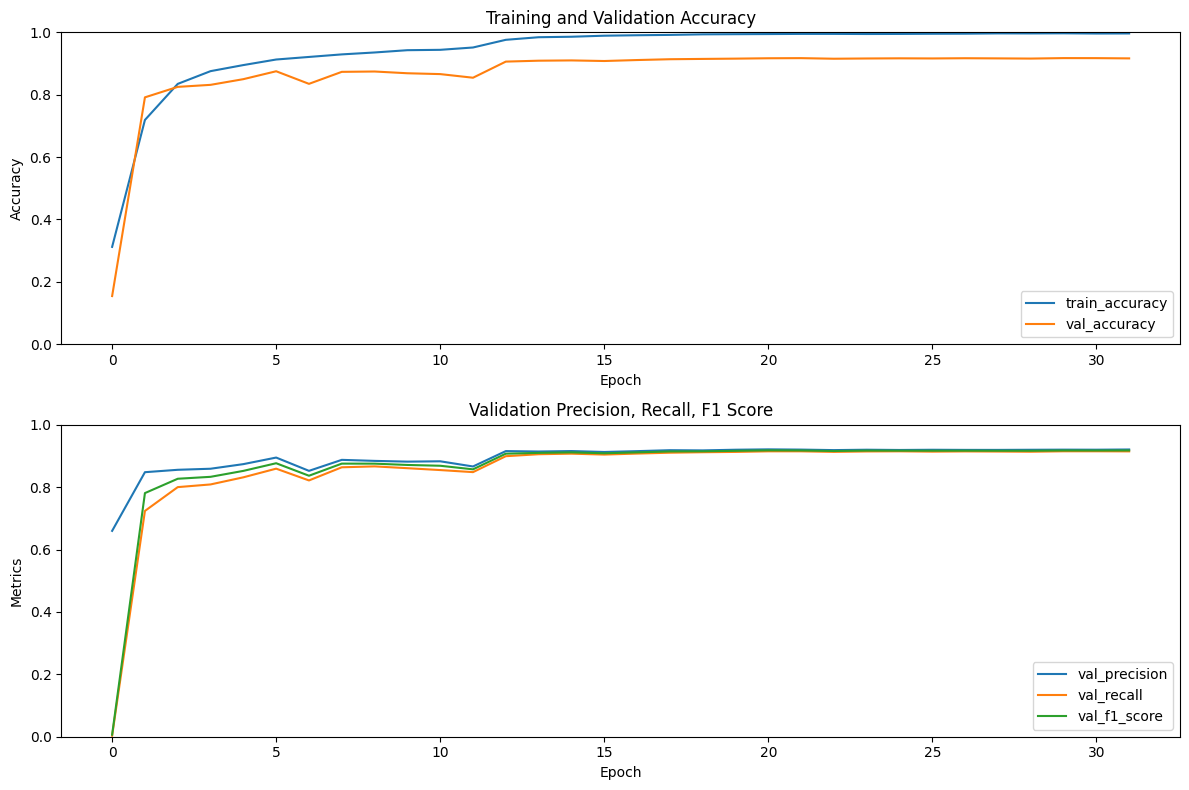

In [9]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(history.history['val_precision'], label='val_precision')
plt.plot(history.history['val_recall'], label='val_recall')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Validation Precision, Recall, F1 Score')

plt.savefig(f'./plots/modelo_T_com_data_augmentation_rmsprop.png')
plt.tight_layout()
#plt.show()